# **Simulando um sistema de detecção de fraudes**

## **Processo**

<img src="https://github.com/OviedoVR/ML_especializacao_2025/blob/main/assets/figures/DeteccaoFraudes_processo.png?raw=true" width="700px"/>


## **Dados**

| Variável                        | Descrição                                                                         |
|-------------------------------|-----------------------------------------------------------------------------------|
| `distance_from_home`              | Distância da residência e local da transação                                      |
| `distance_from_last_transaction`  | Distância da última transação                                                   |
| `ratio_to_median_purchase_price`    | Razão entre a transação realizada e a média da transação realizada pelo cliente |
| `repeat_retailer`               | Transação ocorreu em estabelecimento recorrente? (1 = sim, 0 = não)                     |
| `used_chip`                     | Transação usou o chip?  (**1**: sim, **0**: não)                                      |
| `used_pin_number`                 | Transação usando o PIN?   (**1**: sim, **0**: não)                            |
| `online_order`                  | Transação realizada online?   (**1**: sim, **0**: não)                                    |


## **Case**



### **Detecção de transações suspeitas com Isolatio Forest**


In [255]:
# Bibliotecas:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [256]:
# Carregando os dados:
dados = pd.read_csv('transactions.csv')
dados.head()

,transaction_id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
0,824c05c5edee4aaab66cd83595f8d57c,14.259660,0.296707,0.142657,1,0,0,1
1,a476a471b3024c9abc504ad5477b26e0,20.433218,0.131175,1.856143,1,1,0,1
2,647a8a9bf1a640888bf8f9e26258d680,11.088277,0.108022,1.450553,1,0,0,0
3,335f0112a4f54034a2e0ad86093c0e47,5.740341,2.341908,3.273426,1,0,0,1
4,b388e77a58574853864bc45cd8199ee3,77.771134,0.057858,4.389453,1,1,0,1


In [257]:
# Verificando o tamanho do dataset:
linhas, colunas = dados.shape
print(f'Linhas: {linhas}, Colunas: {colunas}')

Linhas: 10000, Colunas: 8


In [258]:
# Dados nulos:
dados.isna().sum() / len(dados) * 100

,0
transaction_id,0.0
distance_from_home,0.0
distance_from_last_transaction,0.0
ratio_to_median_purchase_price,0.0
repeat_retailer,0.0
used_chip,0.0
used_pin_number,0.0
online_order,0.0


In [259]:
# Estatísticas descritivas:
descritivas = dados.describe().T

# Cálculo do coeficiente de variação:
descritivas['cv'] = descritivas['std'] / descritivas['mean']
descritivas.style.background_gradient(subset='cv')

,count,mean,std,min,25%,50%,75%,max,cv
distance_from_home,10000.000000,26.328473,59.034510,0.067672,3.875412,9.829902,25.509099,2131.156056,2.242231
distance_from_last_transaction,10000.000000,5.091398,22.132065,0.001518,0.298697,0.989845,3.335538,761.519846,4.346953
ratio_to_median_purchase_price,10000.000000,1.840733,2.723906,0.013200,0.479021,0.998549,2.142601,52.020788,1.479795
repeat_retailer,10000.000000,0.879700,0.325328,0.000000,1.000000,1.000000,1.000000,1.000000,0.369817
used_chip,10000.000000,0.349500,0.476836,0.000000,0.000000,0.000000,1.000000,1.000000,1.364337
used_pin_number,10000.000000,0.101400,0.301873,0.000000,0.000000,0.000000,0.000000,1.000000,2.977049
online_order,10000.000000,0.653000,0.476040,0.000000,0.000000,1.000000,1.000000,1.000000,0.729004


In [260]:
# Detecção de possíveis fraudes com IsolationForest:
modelo_if = IsolationForest(
    random_state=35,
    contamination='auto',
)
modelo_if.fit(dados.drop('transaction_id', axis=1))

IsolationForest(random_state=35)

In [261]:
# scores de anomalia
dados['anomaly_score'] = modelo_if.decision_function(dados.drop('transaction_id', axis=1))

# classe (anomalia)
dados['estimated_fraud'] = modelo_if.predict(dados.drop(['transaction_id', 'anomaly_score'], axis=1))
dados['estimated_fraud'] = dados['estimated_fraud'].map({1: 0, -1: 1})

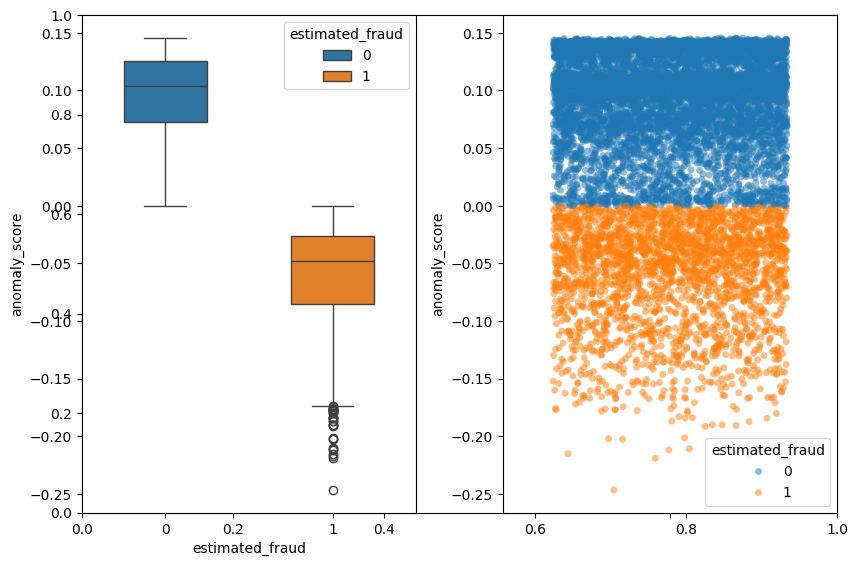

In [262]:
# Data viz.:
fig, ax = plt.subplots(figsize=(9,6));
plt.subplot(1,2,1);
sns.boxplot(dados, x='estimated_fraud', y='anomaly_score', hue='estimated_fraud', width=0.5);
plt.subplot(1,2,2);
sns.stripplot(dados, y='anomaly_score', hue='estimated_fraud', jitter=0.35, alpha=0.5);
plt.tight_layout();

In [263]:
# Proporção fraudes / não-fraudes:
dados['estimated_fraud'].value_counts(normalize=True) * 100

,proportion
estimated_fraud,
0,74.6
1,25.4


### **Transações rotuladas (validadas por time especialista em fraudes)**

In [264]:
transacoes_validadas = pd.read_csv('validated_transactions.csv')
transacoes_validadas.head()

,transaction_id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,824c05c5edee4aaab66cd83595f8d57c,14.259660,0.296707,0.142657,1,0,0,1,0
1,a476a471b3024c9abc504ad5477b26e0,20.433218,0.131175,1.856143,1,1,0,1,0
2,647a8a9bf1a640888bf8f9e26258d680,11.088277,0.108022,1.450553,1,0,0,0,0
3,335f0112a4f54034a2e0ad86093c0e47,5.740341,2.341908,3.273426,1,0,0,1,0
4,b388e77a58574853864bc45cd8199ee3,77.771134,0.057858,4.389453,1,1,0,1,1


In [265]:
transacoes_validadas['fraud'].value_counts(normalize=True) * 100

,proportion
fraud,
0,90.99
1,9.01


In [266]:
# Merge dos dados (obter coluna fraude comprovada):
dados_comparacao = pd.merge(
    transacoes_validadas[['transaction_id', 'fraud']],
    dados,
    how='left',
    on='transaction_id',
)

# Tabela de comparação:
eficiencia_if = pd.crosstab(
    dados_comparacao['fraud'],
    dados_comparacao['estimated_fraud'],
    rownames=['Real'],
    colnames=['Predito']
)

# Resultados:
eficiencia_if

Predito,0,1
Real,,
0,6913,2186
1,547,354


* Fraude, mas o modelo disse que não: 547 (**Falso negativo**)
* Não foi fraude, mas o modelo disse que sim: 2186 (**Falso positivo**)

In [267]:
# Cálculo da acurácia:
acuracia = (6913+354)/len(dados_comparacao) * 100
print(f'Acurácia: {acuracia:.1f} %' )

Acurácia: 72.7 %


### **Aplicando técnicas de aprendizado supervisionado**

In [268]:
# Transações suspeitas
transacoes_suspeitas = dados.query('estimated_fraud == 1')
transacoes_suspeitas.shape

(2540, 10)

In [269]:
# Merge para adicionar o rótulo de fraude nas transações suspeitas:
transacoes_modelagem = pd.merge(
    transacoes_suspeitas,
    transacoes_validadas[['transaction_id', 'fraud']],
    how='left',
    on='transaction_id',
)

# Validação via tamanho do dataset:
print(transacoes_modelagem.shape)

(2540, 11)


In [300]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Dados originais
features = transacoes_modelagem.drop(columns=['fraud', 'transaction_id'])
target = transacoes_modelagem['fraud']  # usar Series 1D

# Dividir em treino e teste (mantendo distribuição original)
x_treino, x_teste, y_treino, y_teste = train_test_split(
    features, target, test_size=0.2, random_state=35, stratify=target
)

# Aplicar undersampling somente no treino
rus = RandomUnderSampler(random_state=35, sampling_strategy='majority')
x_treino_res, y_treino_res = rus.fit_resample(x_treino, y_treino)

# Treinar modelo no treino balanceado
modelo_reg_logistica = LogisticRegression(random_state=35, max_iter=1000)
modelo_reg_logistica.fit(x_treino_res, y_treino_res)

# Prever no teste original (desbalanceado)
y_pred_logistica = modelo_reg_logistica.predict(x_teste)

# Avaliar
print(classification_report(y_teste, y_pred_logistica))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90       437
           1       0.47      0.90      0.62        71

    accuracy                           0.85       508
   macro avg       0.73      0.87      0.76       508
weighted avg       0.91      0.85      0.86       508



In [310]:
# Obter probabilidades previstas para a classe 1 (fraude)
probabilidades_fraude = modelo_reg_logistica.predict_proba(x_teste)[:, 1]

# Testar limiar 0.90:
resposta_ajustada = (probabilidades_fraude >= 0.8).astype(int)
print(classification_report(y_teste, resposta_ajustada))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       437
           1       0.68      0.76      0.72        71

    accuracy                           0.92       508
   macro avg       0.82      0.85      0.84       508
weighted avg       0.92      0.92      0.92       508



In [311]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np

# Inicializar StratifiedKFold para manter proporção das classes em cada fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=35)

# Listas para armazenar métricas
precisoes = []
recalls = []
f1s = []

# Inicializar undersampler
rus = RandomUnderSampler(random_state=35, sampling_strategy='majority')

for index_treino, index_teste in skf.split(features, target):
    # Separar treino e teste originais
    x_treino, x_teste = features.iloc[index_treino], features.iloc[index_teste]
    y_treino, y_teste = target.iloc[index_treino], target.iloc[index_teste]

    # Aplicar undersampling somente no conjunto de treino
    x_treino_res, y_treino_res = rus.fit_resample(x_treino, y_treino.values.ravel())

    # Treinar modelo no conjunto balanceado
    modelo.fit(x_treino_res, y_treino_res)

    # Prever probabilidades para classe 1 no conjunto de teste original
    probabilidades = modelo.predict_proba(x_teste)[:, 1]

    # Ajuste de limiar (valor de corte)
    prob_corte = 0.9
    y_predito = (probabilidades >= prob_corte).astype(int)

    # Relatório
    report = classification_report(y_teste, y_predito, output_dict=True)

    # Armazenar métricas da classe 1 (fraude)
    precisoes.append(report['1']['precision'])
    recalls.append(report['1']['recall'])
    f1s.append(report['1']['f1-score'])

# Exibir média e desvio padrão das métricas
print(f"Precision média: {np.mean(precisoes):.3f} ± {np.std(precisoes):.3f}")
print(f"Recall médio: {np.mean(recalls):.3f} ± {np.std(recalls):.3f}")
print(f"F1-score médio: {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

Precision média: 0.589 ± 0.033
Recall médio: 0.929 ± 0.018
F1-score médio: 0.720 ± 0.020


* **Recall da classe 1 (fraude)**: quanto % das fraudes reais o modelo está identificando?.
* **Precisão da classe 1**: das amostras que o modelo classificou como fraude, quanto realmente são fraudes?
* **F1**: média harmônica entre as duas métricas.